In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import glob
import os
import time
import xarray as xr

# import earthpy as et
# import earthpy.spatial as es
# import earthpy.plot as ep

# import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("talk") #[poster, paper, talk, notebook]

import warnings; warnings.simplefilter('ignore')
mpl.rcParams['agg.path.chunksize'] = 100000

In [2]:
# fontsize, linewitch, etc.
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

In [3]:
def resolution(rez=3):
     
    xy_mu = (300,13500)
    xy_std = (300,15400)
    
    if rez !=3:

        xy_mu = (175,2300)
        xy_std = (175,2600)
    
    return xy_mu, xy_std

xy_mu, xy_std = resolution(3)

In [4]:
fname = '/home/meganmason/Documents/projects/thesis/results/output/compiled_SUPERsnow_20m.nc' #ARS
# fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc' #ARS
# fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
# fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU

# #~~~~ ds load
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})

# #~~~~ ds peak (cloest to peak SWE dates)
dpeak = ds.isel(time=[0,7,18,30,42,49]) #0,7,22,28,41,49]
dpeak.close()

ds = dpeak

#~~~~ ds small
# which_yr = '2016'
# dsmall = ds.sel(time='{}'.format(which_yr))
# dsmall.close()

# ds = dsmall

#~~~convert to cm
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'

#~~~convert to ints again
ds=ds.astype(np.int16, copy=False)

#~~~remove negatives (make them NaNs)
# ds['snow'] = ds.snow.where(ds.snow>0)



#grab 2015, 2016, 2017 nearest peak SWE
ds=ds.isel(time=slice(2,5))
ds.close()

In [5]:
# compute stats from xarray dataset
x_gt0 = ds.snow.where(ds.snow>0) #snow depths greater than zero
mu_gt0 = x_gt0.mean(dim=('x', 'y'))
sig_gt0 = x_gt0.std(dim=('x', 'y'))

#rescaled
# rescaled = (x_gt0 / mu_gt0) 
# print('RESCALED',rescaled)

#standardize
stdize = ((x_gt0 - mu_gt0) / sig_gt0)
# print('\nSTDIZE', stdize)


In [6]:
# x_gt0=x_gt0.astype(np.int16,copy=False)
# stdize=stdize.astype(np.int16,copy=False)

### snow depths

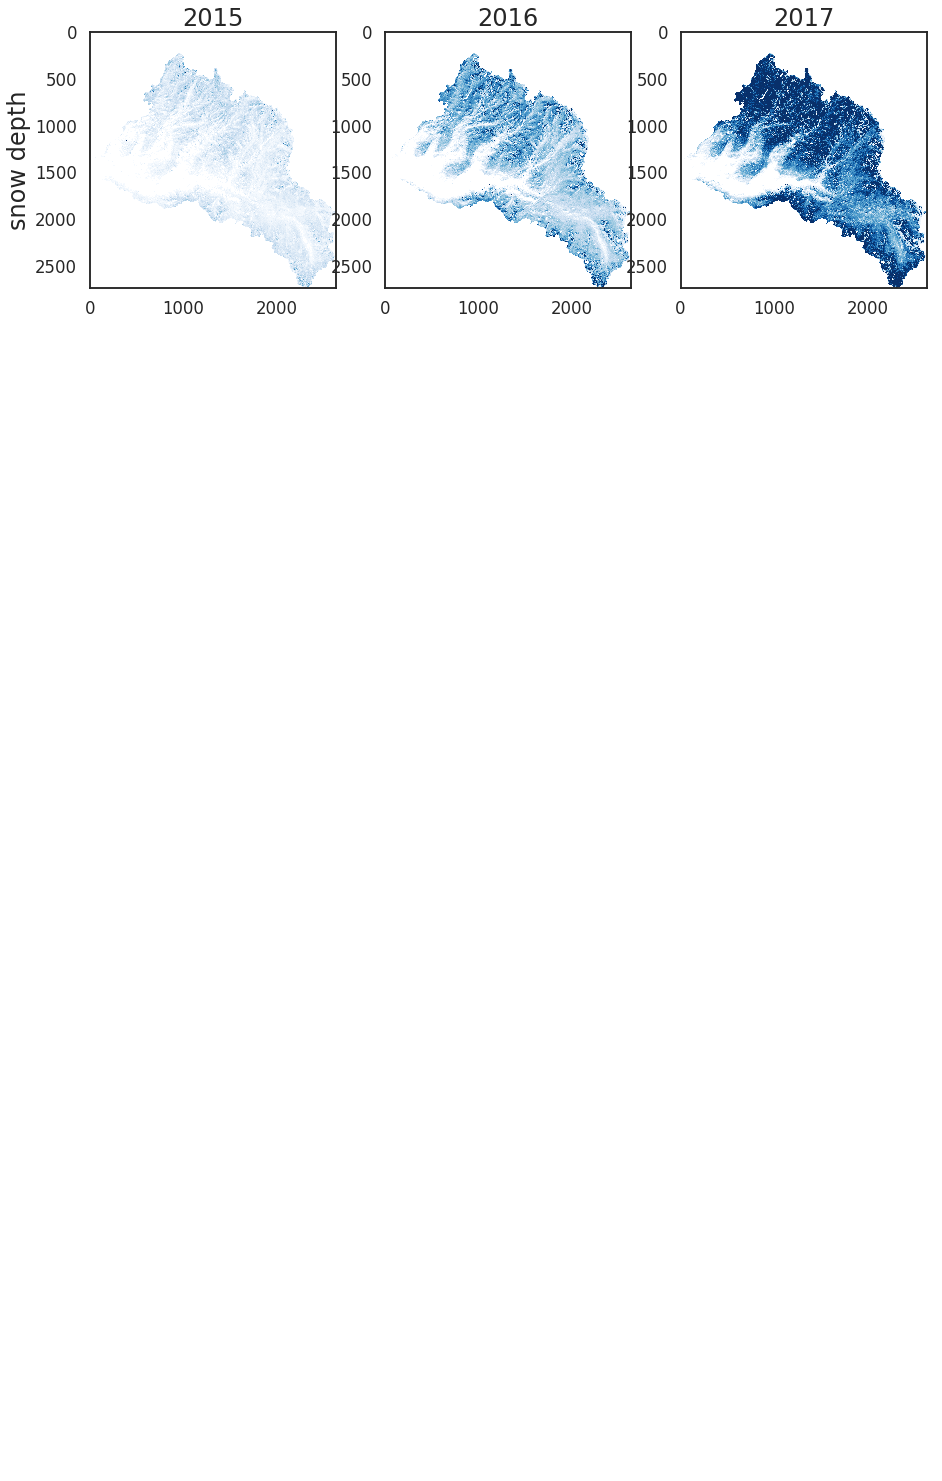

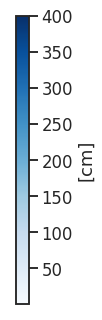

In [7]:
fig, ax=plt.subplots(1,3,figsize=(15,5))
axx=ax.flatten()

labels=[2015,2016,2017]

for i in range(3):
    c0= axx[i].imshow(x_gt0.isel(time=i), cmap='Blues', vmax=400)
    axx[i].annotate('$\mu$ = '+ str(int(np.nanmean(x_gt0[i]))) + ' cm',
                                     xy=xy_mu, 
                                     fontsize=fs_labels-2)
    axx[i].annotate('$\sigma$ = '+ str(int(np.nanstd(x_gt0[i])))+ ' cm',
                                        xy=xy_std, 
                                        fontsize=fs_labels-2)
#     axx[i].axis('off')
    axx[i].set_title(labels[i], fontsize=fs_titles)
    
    
    if i in [0]:
        axx[i].set_ylabel('snow depth', fontsize=fs_labels) #cant see it because axes are 'off'

# plt.savefig('../figs/snowdepths_low_to_high', dpi=300, transparent=True)

#colorbar
fig=plt.figure()
cx0 = fig.add_axes([.1, .1, .03, 1])
fig.colorbar(c0, cax=cx0, orientation='vertical', label='[cm]')
# plt.savefig('../figs/snowdepths_low_to_high_cbar', dpi=300, transparent=True)

### histograms

([<matplotlib.axis.YTick at 0x7f327c4f42b0>,
 <a list of 0 Text yticklabel objects>)

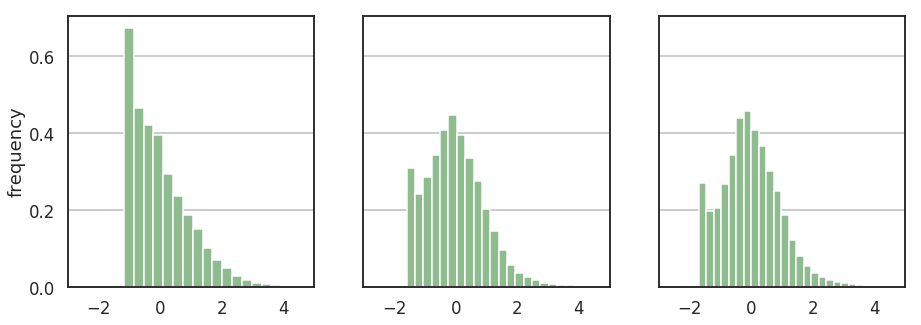

In [8]:
fig, ax=plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
axx=ax.flatten()

# labels=[2015,2016,2017]

for i in range(3):
#     x = sorted(x_gt0.isel(time=i).values.flatten())
#     c0 = axx[i].plot(x, norm.pdf(x), 'r-')
    c0= axx[i].hist(stdize.isel(time=i).values.flatten(), density=True,bins=50, color='darkseagreen') 
    axx[i].set_xlim(-3, 5)
    axx[i].grid(axis='y', color=(0.8, 0.8, 0.8), which='major', linestyle='-', linewidth=2)


    if i in [0]:
        axx[i].set_ylabel('frequency')
        
plt.yticks(np.arange(0, .8, .2))    
# plt.savefig('../figs/standardized_hists_low_to_high', dpi=300, transparent=True)

### standardized imshow()

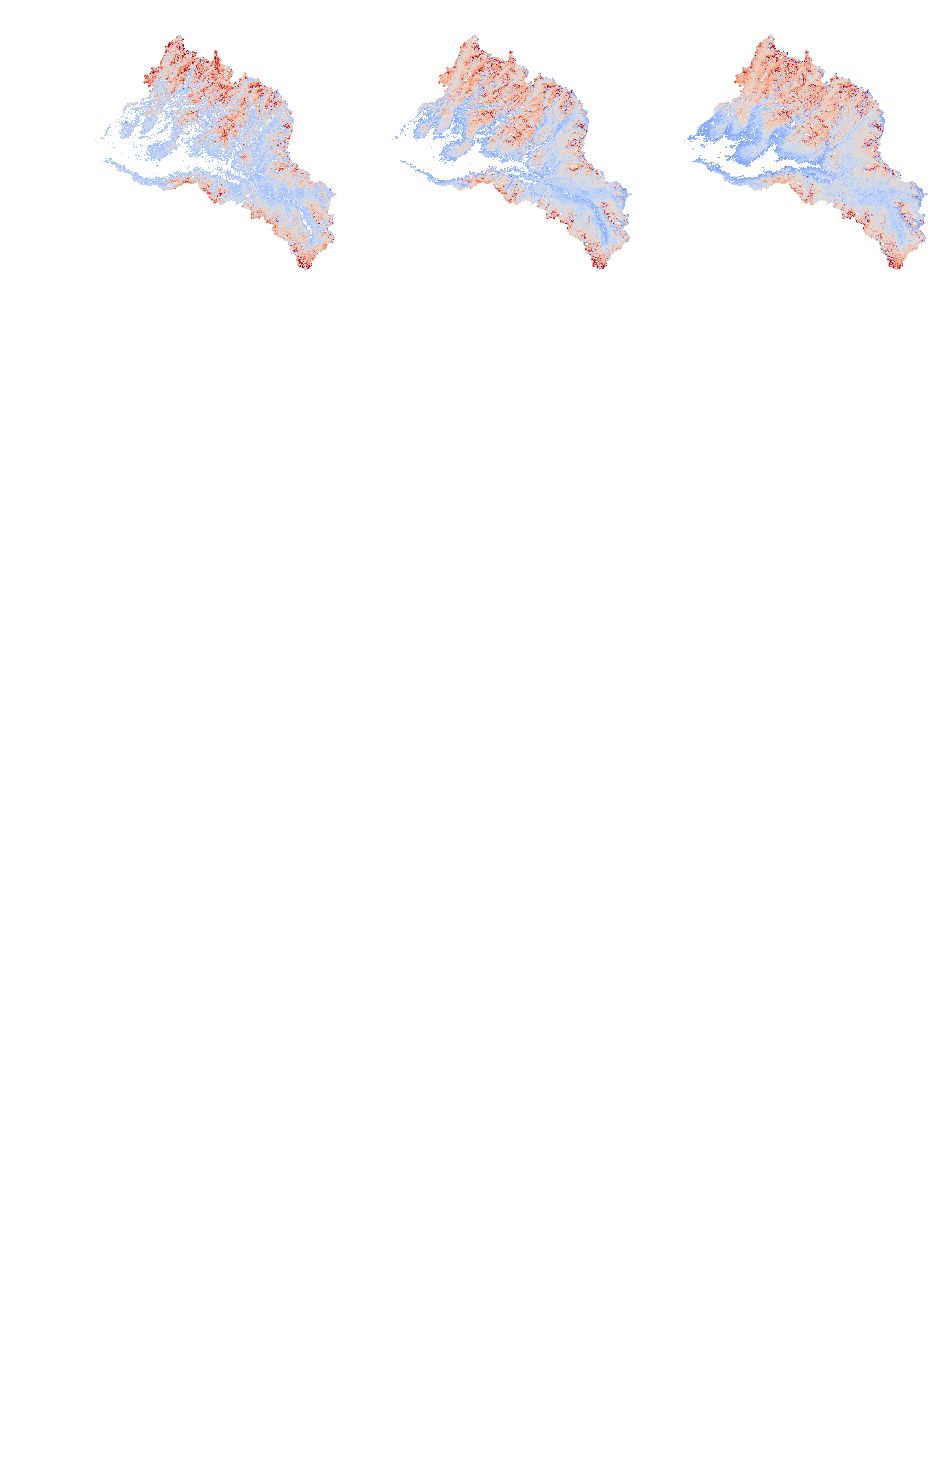

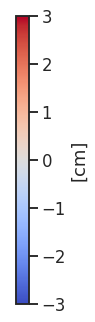

In [9]:
fig, ax=plt.subplots(1,3,figsize=(15,5))
axx=ax.flatten()

for i in range(3):
    c0= axx[i].imshow(stdize.isel(time=i), cmap='coolwarm', vmin=-3 ,vmax=3)
    axx[i].annotate('$\mu$ = '+ str(int(round(np.nanmean(stdize[i])))) + ' cm',
                                     xy=xy_mu, 
                                     fontsize=fs_labels-2)
    axx[i].annotate('$\sigma$ = '+ str(int(round(np.nanstd(stdize[i]))))+ ' cm',
                                        xy=xy_std, 
                                        fontsize=fs_labels-2)
    axx[i].axis('off')

     
    if i in [0]:
        axx[i].set_ylabel('snow depth', fontsize=fs_labels) #cant see it because axes are 'off'

# plt.savefig('../figs/standardized_low_to_high', dpi=300, transparent=True)
        
#colorbar
fig=plt.figure()
cx0 = fig.add_axes([.1, .1, .03, 1])
fig.colorbar(c0, cax=cx0, orientation='vertical', label='[cm]')
# plt.savefig('../figs/standardized_low_to_high_cbar', dpi=300, transparent=True)

### where's deep, where's shallow?!

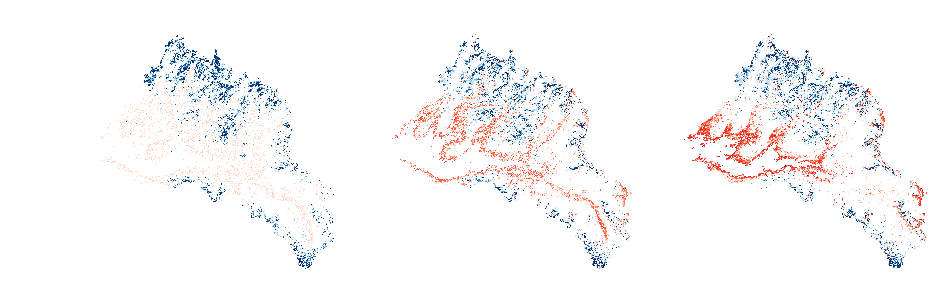

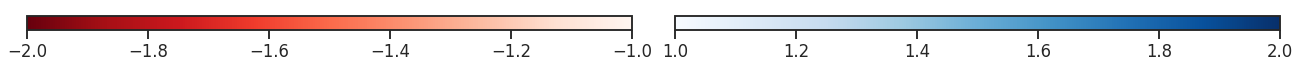

In [10]:
fig, ax=plt.subplots(1,3,figsize=(15,5))
axx=ax.flatten()

#question- can use make imshow just one color (blue and red) vs a color gradient?
#add hillshade!?!?! from bsu...

for i in range(3):
    
    #deep
    deep = stdize.isel(time=i).where(stdize>=1)
#     deep = deep.astype(np.int16,copy=False)
    c0=axx[i].imshow(deep.isel(time=i), cmap='Blues', vmin=1, vmax=2) 
    
    #shallow
    shal = stdize.isel(time=i).where(stdize<=-1)
#     shal = shal.astype(np.int16,copy=False)
    c1=axx[i].imshow(shal.isel(time=i),cmap='Reds_r', vmin=-2, vmax=-1)

    axx[i].axis('off')

     
    if i in [0]:
        axx[i].set_ylabel('deep/shallow zones', fontsize=fs_labels) #cant see it because axes are 'off'
        
# plt.savefig('../figs/deep_shallow_low_to_high', dpi=300, transparent=True)

#colorbar
fig=plt.figure()
cx0 = fig.add_axes([1.6, .37, 1.4, .05])
cx1 = fig.add_axes([.1, .37, 1.4, .05])
fig.colorbar(c0, cax=cx0, orientation='horizontal')
fig.colorbar(c1, cax=cx1, orientation='horizontal')
# plt.savefig('../figs/deep_shallow_low_to_high_cbar', dpi=300, transparent=True)

In [11]:
#THIS MIGHT HELP MAKE A SINGLE BLUE RED COLORMAP
# # make a color map of fixed colors
# cmap = colors.ListedColormap(['white', 'red'])
# bounds=[0,5,10]
# norm = colors.BoundaryNorm(bounds, cmap.N)

# # tell imshow about color map so that only set colors are used
# img = plt.imshow(zvals, interpolation='nearest', origin='lower',
#                     cmap=cmap, norm=norm)

# # make a color bar
# plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 5, 10])

# plt.savefig('redwhite.png')
# plt.show()